# 10 - Introduction to OpenQAOA: An example workflow

This section provides a walkthrough of a simple example workflow, and is intended as a quick introduction to the functionalities of the OpenQAOA library. More focused examples are provided in other sections of the documentation.

The QAOA workflow can be divided in four simple steps:
- Problem definition: Define your optimization problem here, either by: 
    - using pre-defined problem classes or,
    - supplying your own QUBO
- Model building: 
    - Build the QAOA circuit with the available configurations
    - Choose the backend (device) to run the circuit
    - Choose the properties of the classical optimizer
- Compile model and optimize: 
    - Compile the model by passing the problem defined in step-1
    - Execute `model.optimize()` to run the optimization process
- Extract results
    - Run `model.results` to obtain information on the optimization run 

### Begin by importing necessary modules

In [1]:
#some regular python libraries
import networkx as nx
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import problem classes from OQ for easy problem creation
from openqaoa.problems.problem import MaximumCut, NumberPartition

#import the QAOA workflow model
from openqaoa.workflows.optimizer import QAOA

#import method to specify the device
from openqaoa.devices import create_device

### Step 1: Create a problem instance
We begin by creating a problem instance for a simple MaximumCut problem for a random graph created using the python `networkx` module. MaximumCut is a go-to problem to demonstrate QAOA in action.

For this, we first:
- create a random graph using the `networkx` module
- using the MaximumCut problem class, we translate into the QUBO formalism to optimize with QAOA

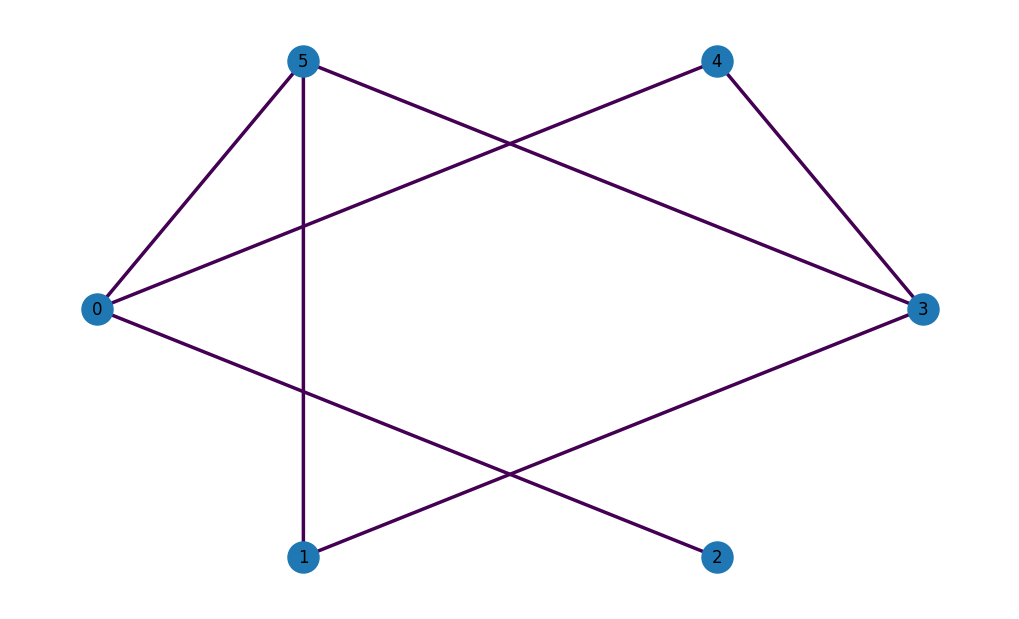

In [2]:
nodes = 6
edge_probability = 0.6
g = nx.generators.fast_gnp_random_graph(n=nodes,p=edge_probability)

# import graph plotter from openqaoa
from openqaoa.utilities import plot_graph
plot_graph(g)

In [3]:
# Use the MaximumCut class to instantiate the problem.
maxcut_prob = MaximumCut(g)

# The method `get_qubo_problem()` translates the problem into a binary Qubo problem. 
# The binary values can be access via the `asdict()` method.
maxcut_qubo = maxcut_prob.get_qubo_problem()

In [4]:
pprint(maxcut_qubo.asdict())

{'_n': 6,
 'constant': 0,
 'terms': [[0, 2], [0, 4], [0, 5], [1, 3], [1, 5], [3, 4], [3, 5]],
 'weights': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}


#### Extract the exact solution for a small enough problem



In [5]:
hamiltonian = maxcut_qubo.hamiltonian

# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -5.0, Solution: ['100100', '110100', '001011', '011011']


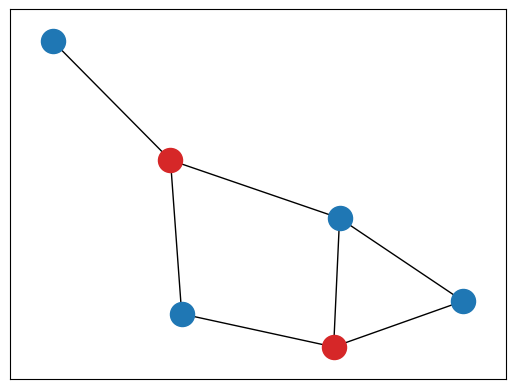

In [6]:
#plot the solution on graph
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos);

### Step 2: Build the QAOA model
 - Initialize the model (with default parameters)
 - Optionally set the following properties for the model
     - `model.set_device(...)`: Set the device
         - The device properties include the location of the device `[local, qcs, ibmq]` and the device name. Full list of devices available at              `openqaoa.workflows.parameters.qaoa_parameters.ALLOWED_DEVICES`
     - `model.set_circuit_properties(...)`: Sets the circuit properties. Mainly used for:
         - `p`: the number of layers
         - `param_type`: the desired parameterisation to be chosen between `['standard', 'extended', 'fourier', annealing]`
         - `init_type`: the initialisation strategy for param_type. To be chosen between `['ramp', 'random', 'custom']`
     - `model.set_backend_properties(...)`
     - `model.set_classical_optimizer(...)`


    
For more details on the configurable properties, please refer to the documentation

In [7]:
# initialize model with default configurations
q = QAOA()

You will need to be authenticated through the AWS CLI to use Braket Backends.

In [8]:
# optionally configure the following properties of the model
# device

device_name = 'arn:aws:braket:::device/quantum-simulator/amazon/sv1'
braket_device = create_device(location='aws', name=device_name)
q.set_device(braket_device)

# circuit properties
q.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q.set_classical_optimizer(method='cobyla', maxiter=10,
                          optimization_progress=True, cost_progress=True, parameter_log=True)

### Step 3: Compile and Optimize

- Once the QAOA model is configured, we need to compile it. **Compilation is necessary** because the QAOA solver has to interact with the problem in to be able to create the underlying QAOA circuit.
- The problem is ready to be optimized now. The user can call `model.optimize()` to initiate the optimization loop. 

In [9]:
q.compile(maxcut_qubo) 

Note that the optimise cell may take a few minutes to terminate!

In [10]:
q.optimize()

### Step 4: Accessing the results

In [11]:
opt_results = q.results

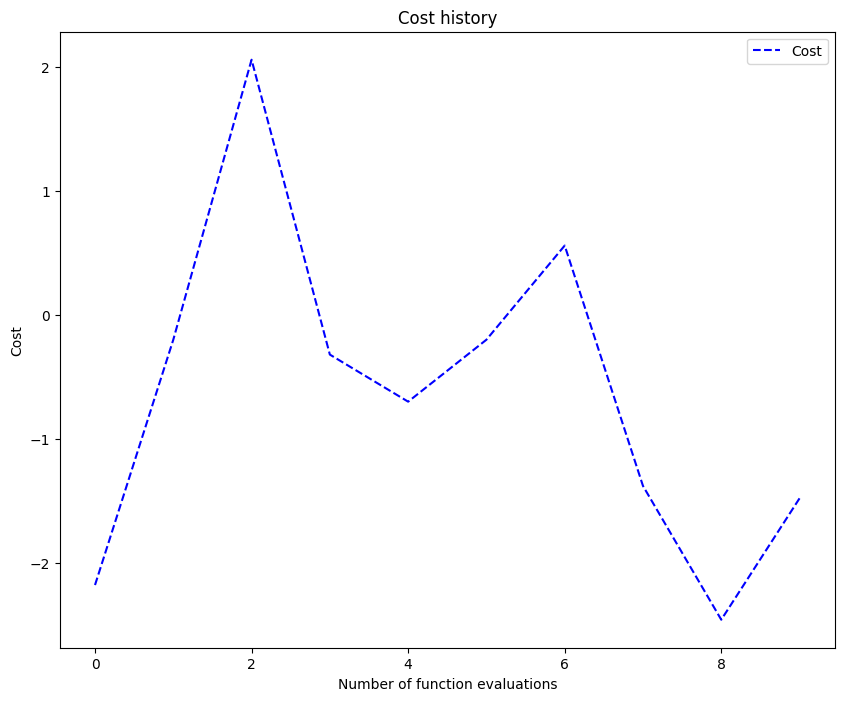

In [12]:
# print the cost history
opt_results.plot_cost()

In [13]:
# prints a large output (commented by default)
# pprint(opt_results.intermediate)

In [14]:
pprint(opt_results.optimized)

{'optimized angles': [3.1073625994855716,
                      1.9779756306733614,
                      0.8054435497939857,
                      2.707314372331024],
 'optimized cost': -2.4599999999999995,
 'optimized measurement outcomes': Counter({'100100': 8,
                                            '011011': 6,
                                            '001101': 6,
                                            '110010': 6,
                                            '000011': 5,
                                            '011010': 5,
                                            '011110': 5,
                                            '100101': 5,
                                            '001011': 5,
                                            '110100': 4,
                                            '101100': 4,
                                            '001111': 3,
                                            '011001': 3,
                                            '110001

In [15]:
variational_params = q.optimizer.variational_params

In [16]:
#create the optimized QAOA circuit for qiskit backend
optimized_angles = opt_results.optimized['optimized angles']
variational_params.update_from_raw(optimized_angles)
optimized_circuit = q.backend.qaoa_circuit(variational_params)

#print the optimized QAOA circuit for qiskit backend
optimized_circuit.diagram()

'T  : |0| 1 |   2    | 3 |     4     |   5    |6| 7 |   8    | 9 |        10         |   11   |    12    |    13     |        14        |    15    |    16     |17 |   18   |19 |    20     |   21   |22 |        23         |   24   |25|   26    |Result Types|\n                                                                                                                                                                                                                                                                \nq0 : -H-C------------C---C--------------------C-C------------C---Rx(-6.21)-----------C-----------------------------C-C---------------------------------------C-C------------C---Rx(-3.96)----------------------------------------------------------Probability--\n        |            |   |                    | |            |                       |                             | |                                       | |            |                                                    